# Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Lasso, LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import root_mean_squared_error
import pickle

In [ ]:
df = pd.read_csv("../input/students-performance-in-exams/StudentsPerformance.csv")
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


# Data Exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [4]:
df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


<Axes: >

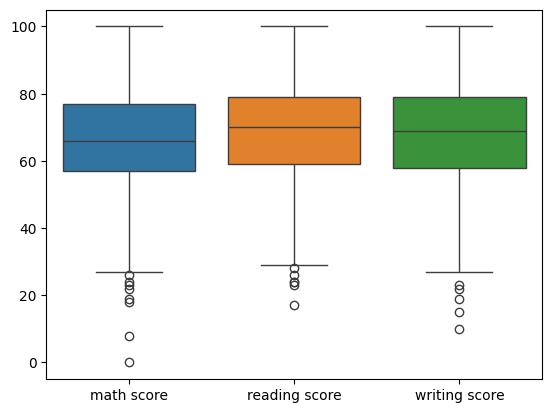

In [5]:
sns.boxplot(data=df)

# Data Preparation

In [ ]:
df["final score"] = df.apply(
    lambda x: (x["math score"] + x["reading score"] + x["writing score"]) / 3, axis=1
)
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,final score
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


In [ ]:
X = df.drop("final score", axis=1)
y = df["final score"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_c = X_train.copy()
X_test_c = X_test.copy()

# Feature Enineering

In [ ]:
# ordinal encoding parental level of education column
education = [
    [
        "master's degree",
        "bachelor's degree",
        "associate's degree",
        "some college",
        "high school",
        "some high school",
    ]
]

ordinal_enc = OrdinalEncoder(categories=education, dtype=np.int64)
X_train_c.loc[:, ["parental level of education"]] = ordinal_enc.fit_transform(
    X_train.loc[:, ["parental level of education"]]
)
X_test_c.loc[:, ["parental level of education"]] = ordinal_enc.transform(
    X_test.loc[:, ["parental level of education"]]
)

In [ ]:
# one hot encoding another category column
category = ["gender", "race/ethnicity", "lunch", "test preparation course"]

onehot_enc = OneHotEncoder(dtype=np.int64, sparse_output=False, drop="first")
onehot_train = pd.DataFrame(
    onehot_enc.fit_transform(X_train[category]),
    columns=onehot_enc.get_feature_names_out(),
)
onehot_test = pd.DataFrame(
    onehot_enc.transform(X_test[category]), columns=onehot_enc.get_feature_names_out()
)

# set index again
onehot_train.index = X_train_c.index
onehot_test.index = X_test_c.index

# drop category columns
X_train_c.drop(category, inplace=True, axis=1)
X_test_c.drop(category, inplace=True, axis=1)

# concat encoded columns
X_train_c = pd.concat([X_train_c, onehot_train], axis=1)
X_test_c = pd.concat([X_test_c, onehot_test], axis=1)

# Modelling

In [20]:
def score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = root_mean_squared_error(y_test, y_pred)
    return score

In [21]:
lasso = Lasso()
linreg = LinearRegression()
rf = RandomForestRegressor(n_estimators=100, random_state=42)
svr = SVR(C=0.5)
# xgb = XGBRegressor(n_estimators=1000, random_state=42)

models = [lasso, linreg, rf, svr]
scores = []
for m in models:
    scores.append(score(m, X_train_c, X_test_c, y_train, y_test))

In [27]:
print(scores)
print("RMSE: ", np.min(scores))

[0.07500740645926683, 1.8965053153800233e-14, 1.1285072982582858, 3.192112572296892]
RMSE:  1.8965053153800233e-14


In [23]:
print(y_test.head())
linreg.predict(X_test_c.head())

521    87.000000
737    64.000000
740    75.000000
660    74.666667
411    81.666667
Name: final score, dtype: float64


array([87.        , 64.        , 75.        , 74.66666667, 81.66666667])

# Save model and encoding to pickle

In [ ]:
pickle.dump(linreg, open("../model/_model_linreg.pkl", "wb"))
print("saved model successfully!")

pickle.dump(onehot_enc, open("../model/_enc_onehot.pkl", "wb"))
print("saved onehot encoder successfully!")

pickle.dump(ordinal_enc, open("../model/_enc_ordinal.pkl", "wb"))
print("saved ordinal encoder successfully!")

saved model successfully!
saved onehot encoder successfully!
saved ordinal encoder successfully!
